<a href="https://colab.research.google.com/github/MarioAuditore/gel_code_cryptosystem/blob/main/%D0%A4%D0%B8%D0%BD%D0%B0%D0%BB_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%E2%84%96389_%D0%9A%D1%80%D0%B8%D0%BF%D1%82%D0%BE%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_GLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Принцип работы
https://docs.google.com/document/d/1wZh7OQzCrNuyKjhjgMV4VcaFkr9LenT3ZpGOFUlGOcE/edit?usp=sharing

In [ ]:
pip install --upgrade unireedsolomon

In [ ]:
pip install galois

In [ ]:
# проблемы с numba, которая есть в Galois
# ей нужна особая версия numpy, а galois устанавливает новейшую по умолчанию

In [ ]:
pip install --upgrade numpy==1.20

#Определим избыточность внешних кодов.


In [ ]:
import galois
import numpy as np
#---------------------
import math
from array import array
import random
#---------------------
import unireedsolomon as rs
from unireedsolomon import polynomial as pl
from unireedsolomon import ff
#---------------------

In [ ]:
def C(n, k):  # определим число перестановок
    if 0 <= k <= n:
        nn = 1
        kk = 1
        for t in range(1, min(k, n - k) + 1):
            nn *= n
            kk *= t
            n -= 1
        return nn // kk
    else:
        return 0

In [ ]:
# обработка вероятностей
n_A = 8  # характеристика внутреннего кода (число строк или длина столбца) tA_j=rA_j/2   rA_j--число проверочных символов jго внутр кода
L = int(np.ceil(n_A/2))  # Число вложенных, пока задается тут 
n_B = 255  # характеристика внешнего кода (число столбцов или длина строки)
p = 0.0143  # заданная вероятность ошибки в канале
p_f = 10**(-10)  # заказанная вероятность ошибки для внешнего кода

p_A = [0]*L 
p_B = [0]*L
t_B = np.array([0]*L)  # число ошибок
r_B = np.array([1]*L)  # избыточность    

def unoptimised_prob(p, stats = True):
  #-------------------------------- вероятность ошибки в столбцах--------------
  for j in range(len(p_A)):
      sum_buffer = 0  # используем для хранения суммы
      for i in range ((j+1),n_A+1):
        sum_buffer += C(n_A,i)*pow(p,i)*pow((1-p),(n_A-i))
      p_A[j] = sum_buffer
      
  if stats:
    print('probability of errors in columns',p_A)
  #----------------------------- вероятность ошибки внешнего кода-------------
  for j in range(len(p_A)):  # сперва посчитаем все суммы, потом последовательно будем вычитать
      sum_buffer = 0  # используем для хранения суммы
      for i in range (1,n_B+1):
        sum_buffer += C(n_B,i)*pow(p_A[j],i)*pow((1 - p_A[j]),(n_B-i))
      p_B[j] = sum_buffer

  if stats:
    print('external code error probability ',p_B)
  #------------------------------ поиск tb_j--------------
  for j in range(len(p_B)):  # алгоритм такой: мы знаем итоговую сумму, надо найти наименьшее tb_j, 
    i = 1                    # значит просто будем вычитать первые элементы суммы
    sum_buffer = p_B[j]
    while (sum_buffer > (p_f/L)):
      sum_buffer = sum_buffer - C(n_B,i)*(p_A[j])**i*(1 - p_A[j])**(n_B-i)
      if (sum_buffer <= (p_f/L)):
        t_B[j] = i
        break
      else:
        i+=1
  if stats:
    print('t_B',t_B)
  #----------------------поиск неоптимизированной избыточности---------------------
  for j in range(L):
    r_B[j] = min(2*t_B[j],n_B)

  return p_A, p_B, t_B, r_B

p_A, p_B, t_B, r_B = unoptimised_prob(p)

print('r_B',r_B)
print('p_A',p_A)

probability of errors in columns [0.10883514170872288, 0.005406857455377933, 0.00015517273702557902, 2.7955604557531586e-06]
external code error probability  [0.9999999999998265, 0.7490469703042475, 0.03879936864332032, 0.0007126148819753808]
t_B [65 14  5  3]
r_B [130  28  10   6]
p_A [0.10883514170872288, 0.005406857455377933, 0.00015517273702557902, 2.7955604557531586e-06]


In [ ]:
#------------------- вероятность ошибки по заданной избыточности -----------------
def error_probability(r_B,n_A,n_B,p,L):
  p_A = [0]*L
  p_B = [0]*L
  for j in range(len(p_A)):
    sum_buffer = 0  # используем для хранения суммы
    for i in range ((j+1),n_A+1):
      sum_buffer += C(n_A,i)*p**(i)*(1-p)**(n_A-i)
    p_A[j] = sum_buffer

  for j in range(len(p_A)):  # теперь вероятности для p_B
    sum_buffer = 0  # используем для хранения суммы
    i = math.ceil(r_B[j]/2)
    while i <= n_B:
      sum_buffer += C(n_B,i)*(p_A[j])**i*(1 - p_A[j])**(n_B-i)
      i += 1
    p_B[j] = sum_buffer
  sum_buffer = 0
  for j in range(len(p_B)):
    sum_buffer += p_B[j]
  return min(sum_buffer,1)

In [ ]:
#------------------------------оптимизация----------------------------------

def optimised_code_params(p):

  r_B_optimised = np.array([[0]*L]*L)
  r_B_result = r_B
  stop_flag = 0  # активируется, если набор r_B[j] не изменится после 2-ух итераций
  r_B_previous = ""  # если наш алгоритм достигнет наилучшей вероятности, то он просто начнет "скакать", т.е. будет поочердно прибавлять и отнимать избыточность
  p_variations = [0]*L  # будем хранить вероятности всех вариаций
  p_min_index = 0  # индекс элемента с минимальной вероятностью

  while stop_flag==0:
    if error_probability(r_B_result,n_A,n_B,p,L) < p_f:  # если после наших махинаций вероятность будет больше, то нужно останавливаться. Заходим в увеличение избыточности и потом выходим
      for j, row in enumerate(r_B_optimised):  
        for k, item in enumerate(row):
          if (j==k):
            r_B_optimised[j][k] = (r_B_result[k] - 2)
          else:
            r_B_optimised[j][k] = r_B_result[k]
      for j, item in enumerate(p_variations):
        p_variations[j] = error_probability(r_B_optimised[j],n_A,n_B,p,L)
      p_min_index = np.argmin(p_variations)
      r_B_result = r_B_optimised[p_min_index]
      r_B_previous = "-2"                               

    elif error_probability(r_B_result,n_A,n_B,p,L) > p_f:
      for j, row in enumerate(r_B_optimised):  
        for k, item in enumerate(row):
          if (j == k):
            r_B_optimised[j][k] = (r_B_result[k] + 2)
          else:
            r_B_optimised[j][k] = r_B_result[k]
      for j, item in enumerate(p_variations):  
        p_variations[j] = error_probability(r_B_optimised[j],n_A,n_B,p,L)
      p_min_index = np.argmin(p_variations)
      r_B_result = r_B_optimised[p_min_index]
      if r_B_previous == "-2":
        stop_flag = 1
      
  return r_B_result
      
r_B_result = optimised_code_params(p)

print('p_f =',p_f,', we got p =',error_probability(r_B_result,n_A,n_B,p,L))
print(r_B,' - r_B')
print(r_B_result,' - r_B_result')
k = [n_B - i for i in r_B_result]  # запоминаем число информационных симолов, вместе с избыточностями

p_f = 1e-10 , we got p = 5.541626373417708e-11
[130  28  10   6]  - r_B
[130  32  12   8]  - r_B_result


#Функции для ОЛО-кодов

In [ ]:
#-----------генерация матрицы кода Рида-Соломона-------------
def Generate_Reed_Solo_generic_matrix (n, k, gen, prime, c_exp):
  coder = rs.RSCoder(n=n, k=k, generator=gen, prim=prime, fcr=1, c_exp=c_exp)
  generic_poly = [int(i) for i in coder.g[k]]
  G = []
  print('generic polynomial =',generic_poly)
  for i in range(n - len(generic_poly) + 1):
    buf = [0] * i + generic_poly
    buf = buf + [0] * (n - len(buf))
    G.append(buf)
  for i in range(1,len(G)):
    j = 0
    while j < i:
      coef = G[j][i]
      G[j] = [ff.GF2int(G[j][x]) - ff.GF2int(coef)*ff.GF2int(G[i][x]) for x in range(len(G[0]))]
      j+=1
  G[len(G) - 1] = [ff.GF2int(G[len(G) - 1][j]) for j in range(len(G[0]))]
  return G

In [ ]:
from numpy import linalg as LA
import secrets  # для (криптографически) хорошей случайной генерации 
import random  # случайная генерация

np.set_printoptions(suppress=True)

#-----------для обработки ошибок list.index()-----------
def index_of(val, in_list): 
    try:
        return in_list.index(val)
    except ValueError:
        return -1 
#-------для вставки нулей при обработке многочленов-----
def insert_left(lst,n):
  return [(0)]*(n - len(lst)) + [i for i in lst]
#-----------переводим элементы матрицы в элементы поля---
def matrix_to_GF(g): 
  result = []
  for i in range(len(g)):
    buf = [ff.GF2int(j) for j in g[i]]
    result.append(buf)
  
  return result


#-----------------генератор матриц для системы Мак-Элиса------------
def McElise_matrices(g, GF, stats = False,calculate_s=False,calculate_p=False):
    a = np.asarray(g).shape[0]      # алгоритм генерации сделан Данилом Кадочниковым СКБ-191
    b = np.asarray(g).shape[1]
    if stats:
      print("Матрица G:\n", g, "\n")
      print("na = ", a, ", nb = ", b, "\n", sep = '')
    #=======невырожденная матрица===========
    if calculate_s:  # если надо будет посчитать только невырожденную матрицу
      s = GF(np.random.randint(2 **GF.degree, size = (a, a)))
      while (LA.det(s) == 0):  # нам нужна невырожденная матрица, значит будем искать ее пока определитель не станет отличен от нуля
        s = GF(np.random.randint(2, size = (a, a)))

      if stats:
        print("Матрица S:")
        print(s, "\n")
      if not calculate_p:
        return s
    #=======перестановочная матрица========
    if calculate_p:
      p = np.zeros((b, b), dtype = int)
      positions_row = []
      positions_column = []
      for i in range(b):

        # вычисляем ряды
        j = secrets.randbelow(b)
        while index_of(j,positions_row) != -1:
          j = secrets.randbelow(b)
        positions_row.append(j)

        # вычисляем столбцы
        q = secrets.randbelow(b)
        while index_of(q,positions_column) != -1:
          q = secrets.randbelow(b)
        positions_column.append(q)

      inverse1 = secrets.randbelow(2)
      if inverse1 == 1:
        positions_row = positions_row[::-1]
      inverse2 = secrets.randbelow(2)
      if inverse2 == 1:
        positions_column = positions_column[::-1]

      for i in range(b):
        p[positions_row[i]][positions_column[i]] = 1
    
      p = GF(np.array(p,dtype=int))
      if stats:
        print("Матрица P:")
        print(p, "\n")
      if not calculate_s:
        return p
    if (calculate_p and calculate_s):
      return s, p

In [ ]:
#----------------------пример-----------------------------------  
import random  
ga = random.randint(10, 20)
gb = random.randint(10, 20)
s, p = McElise_matrices(np.random.randint(50, size = (ga, gb)), galois.GF(2**4), calculate_p=True, calculate_s=True, stats=True)

Матрица G:
 [[37 48  3  2 16 13 43  0 21 13 49]
 [35 42  7 15 34 20 36 13 31 37 20]
 [38 24 12 37 19 27 29 46 34 29 15]
 [18 12 16 33 42 38 46 26 41  5 32]
 [ 9 29 18 32 16 39 20 10 42 35 17]
 [20  8 39 38 20 38 21 40  0 18 24]
 [32 20 23 40 49 18 31  9 48 38 26]
 [45 17 18  7  1 33 14  9 26 11 43]
 [34  5 16  0  0 36 15 29 21  5 24]
 [40 15  4  0 14  8 41 16 48 33  1]] 

na = 10, nb = 11

Матрица S:
GF([[ 4,  2,  7, 15,  2,  1,  9, 13, 14,  0],
    [ 0,  4, 13,  4, 15,  6, 15,  3, 10,  1],
    [ 9,  0, 12,  5, 14, 15,  9,  2, 10,  3],
    [ 7,  2,  5, 15, 11, 11,  1,  5,  2,  5],
    [ 8, 15,  6,  2, 13, 13, 10, 15, 11, 11],
    [ 0, 14,  6,  9,  8,  3,  8,  5,  7, 14],
    [13, 10,  6, 13,  2,  7,  7,  7,  7,  8],
    [11,  4,  9,  6, 14, 13,  9,  5,  2,  9],
    [ 6,  2,  1,  9,  1,  3,  4, 10,  4, 12],
    [ 5,  1,  5,  5, 15,  9,  8, 11,  1,  3]], order=2^4) 

Матрица P:
GF([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1

#Кодирование внешними кодами 

In [ ]:
#------------------------------------ кодирование внешними кодами ----------------------------------------------
# n_A - число строк
# n_B - число столбцов
c_exp_inner = 4  # поле внутренних кодов
c_exp_outer = 2*c_exp_inner  # поле внешних кодов -- размер 2^8 = 256 = n_B + 1 

# создаем поля
GF_inner = galois.GF(2**c_exp_inner)
GF_outer = galois.GF(2**c_exp_outer)

gen = 2  # задаем порождающий эелемент поля

outer_prime = 285

ff.init_lut(generator=gen,prim=outer_prime,c_exp=c_exp_outer)  # иницализируем собственное поле из библиотеки unireedsolo

# матрицы внешнего кода умножаются на слои и существуют над бОльшим полем
G = [GF_outer(Generate_Reed_Solo_generic_matrix(n_B, k_var, gen=gen, prime=outer_prime, c_exp=c_exp_outer)) for k_var in k]  # создаем попрождающие матрицы кодов

generic polynomial = [1, 193, 203, 228, 101, 140, 105, 109, 151, 46, 191, 130, 244, 40, 172, 209, 180, 169, 250, 171, 41, 48, 42, 46, 242, 117, 175, 35, 178, 3, 37, 6, 37, 25, 6, 3, 205, 101, 107, 37, 56, 41, 237, 249, 89, 178, 156, 117, 133, 53, 131, 61, 105, 227, 108, 17, 18, 159, 243, 85, 220, 102, 61, 71, 81, 21, 107, 32, 206, 132, 60, 179, 46, 137, 133, 169, 209, 43, 245, 234, 123, 226, 185, 107, 122, 6, 228, 37, 94, 245, 209, 204, 10, 215, 88, 46, 128, 5, 143, 77, 192, 170, 242, 150, 52, 209, 122, 234, 145, 196, 219, 107, 6, 70, 95, 231, 76, 235, 39, 102, 144, 188, 200, 231, 158, 16, 183, 199, 137, 19, 17]
generic polynomial = [1, 232, 29, 189, 50, 142, 246, 232, 15, 43, 82, 164, 238, 1, 158, 13, 119, 158, 224, 134, 227, 210, 163, 50, 107, 40, 27, 104, 253, 24, 239, 216, 45]
generic polynomial = [1, 136, 193, 34, 51, 130, 147, 167, 170, 132, 175, 252, 120]
generic polynomial = [1, 227, 44, 178, 71, 172, 8, 224, 37]


In [ ]:
print(G[0])

GF([[  1,   0,   0, ...,  45, 122, 229],
    [  0,   1,   0, ..., 181, 121, 193],
    [  0,   0,   1, ...,  66, 239, 128],
    ...,
    [  0,   0,   0, ..., 165,  44,  73],
    [  0,   0,   0, ..., 128, 195,  77],
    [  0,   0,   0, ..., 137,  19,  17]], order=2^8)


#Создание открытых ключей из порождающих матриц 
$G_{open}^{i} = S^{i} \cdot G^{i} \cdot P$, где $i$ -- индекс




In [ ]:
P_G_private = GF_outer(McElise_matrices(G[0], GF_outer, calculate_p=True))  


S_G_private = []  # это закрытые ключи
G_open = []  # это открытые ключи
for i in range(len(G)):
  S = GF_outer(McElise_matrices(G[i], GF_outer, calculate_s=True))
  S_G_private.append(S)  # закрытый ключ -- матрица P
  G_open.append(S @ G[i] @ P_G_private)  # открытый ключ -- произведение матриц

# Т.е. из порождающих матриц кода Рида-Соломона мы создаем открытые ключи G_open
# из закрытых ключей:: P_G_private, S_G_private, G.

In [ ]:
print(G_open[0])

GF([[ 31, 130, 183, ...,  22, 235,  50],
    [  5, 197, 224, ..., 180, 171,  58],
    [ 90, 171, 163, ..., 222, 108,   3],
    ...,
    [224, 200,  94, ..., 202,  94, 166],
    [100, 220,  10, ..., 135,  33, 146],
    [ 95,  64,  50, ..., 117, 103, 141]], order=2^8)


#Создание сообщения

In [ ]:
message = []
# сообщение само по себе существует над мЕньшим полем (внутренним)
for j in range(L):#на каждый слой
  buf = []
  for i in range(2):#по два сообщения
    buf.append(np.random.randint(low = 0, high = 2**c_exp_inner - 1, size = k[j]))
  message.append(buf)
  
# длина message равна L, а размер каждого его элемента 2xk

#Функции перевода слоя матрицы (слой это две строки) в вектор, принадлежащий полю внешних кодов.

In [ ]:
def msg_layer_to_vector (A, layer, GF):
  # нужно внешнее поле GF_outer
  # слой -- это матрица размера 2 на n_B
  # А -- какое поле у внутреннего кода
  new_layer = []
  for i in range(len(layer[0])):
    new_layer.append(int(layer[0][i]) * A + int(layer[1][i]))
    # т.е. сообщение для внешнего кода состоит из символов вида x[0][i]*A^(1) + x[1][i]*A^(0)
    # самый высокий разряд у верхнего символа, а у нижнего -- наименьший
  # все операции происходят вне поля, но так как символы сообщения
  # варируются от 0 до А-1 в новое поле мы войдем корректно, ведь B=A^2
  return GF(new_layer)

def msg_vector_to_layer(A, msg, GF):
  # перед применением нужно передать внутреннее поле GF_inner
  # сообщение с символами от 0 до A^2
  layer = []
  layer1 = []
  layer2 = []
  for i in range(len(msg)):
    # перевод обратно в слой должен быть вне поля,
    # но сам результат нужно делать элементом поля GF(A)
    layer1.append(int(msg[i]) // A)
    layer2.append(int(msg[i]) % A)
  layer.append(GF(layer1))
  layer.append(GF(layer2))
  return layer

# Таким образом, если в нашу матрицу прибавить ошибку типа |1| то для внешнего кода это будет ошибка 1*A + 0*A = A
#                                                          |0|
# При декодировании ошибки надо будет переводить в слоистый вид, чтобы понимать как с ними работать при внешних кодах

#Кодирование первыми открытыми ключами

In [ ]:
# c_exp_inner - внутренние коды
# c_exp_outer - внещние коды
outer_code_msg_vector = []

for j in range(L):#на каждый слой
  outer_code_msg_vector.append(np.array(msg_layer_to_vector(2**c_exp_inner, message[j], GF_outer) @ G_open[j]))
# получаем кодовые слова внешнего кода
outer_code_msg_vector = GF_outer(np.array(outer_code_msg_vector))
print(outer_code_msg_vector.shape)

(4, 255)


In [ ]:
#------------------проверка, что при декодировании получим наше сообщение---------------------------
coder = rs.RSCoder(n = n_B, k = k[0], generator=gen, prim = outer_prime, fcr = 1, c_exp = c_exp_outer)

decoded,_ = coder.decode(outer_code_msg_vector[0] @ LA.inv(P_G_private), k = k[0], return_string=False)
decoded = insert_left(np.array(decoded), k[0])

check = msg_layer_to_vector(2**c_exp_inner,message[0], GF_outer)
print(GF_outer(np.array(decoded)) @ LA.inv(S_G_private[0]) == check)
print(decoded,check, sep = '\n')

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[72, 208, 127, 107, 253, 188, 91, 147, 135, 144, 71, 85, 107, 133, 195, 190, 215, 11, 40, 209, 114, 176, 58, 178, 41, 63, 231, 148, 91, 211, 9, 159, 144, 87, 151, 25, 66, 125, 166, 111, 150, 34, 236, 150, 26, 18, 185, 36, 23, 5, 153, 231,

In [ ]:
# переводим обратно в слоистую структуру, но уже в виде двумерной матрицы
outer_code_msg = []
for j in range(L):
  buf = msg_vector_to_layer(2**c_exp_inner, outer_code_msg_vector[j], GF_outer)
  outer_code_msg.append(np.array(buf[0]))
  outer_code_msg.append(np.array(buf[1]))

outer_code_msg = GF_inner(np.array(outer_code_msg))
print(outer_code_msg)

GF([[ 2,  3,  0, ...,  2,  0, 13],
    [ 8,  3,  9, ...,  5,  8,  7],
    [14,  5,  7, ...,  0, 13,  8],
    ...,
    [ 9,  4, 15, ...,  6,  6,  1],
    [15,  6,  0, ...,  8,  5,  2],
    [ 5,  1,  6, ..., 12, 15, 11]], order=2^4)


#Заготовка синдромов внутренних кодов
Этот этап необходим, так как по нему мы определим векторы ошибок, чтобы их вычесть из зашумленной матрицы (нашего сообщения)

In [ ]:
#----------------------------внутренние коды------------------------------------
gen = 2
inner_prime = ff.find_prime_polynomials(generator=gen,c_exp=c_exp_inner,single=True)

ff.init_lut(generator=gen,prim=inner_prime,c_exp=c_exp_inner)  # инициализируем поле GF(16)

H = []  # матрица будет квадратной

for i in range(n_A):
  H.append([(ff.GF2int(gen)**i)**j for j in range(n_A)])
H = GF_inner(np.array(H))
print(H)

GF([[ 1,  1,  1,  1,  1,  1,  1,  1],
    [ 1,  2,  4,  8,  3,  6, 12, 11],
    [ 1,  4,  3, 12,  5,  7, 15,  9],
    [ 1,  8, 12, 10, 15,  1,  8, 12],
    [ 1,  3,  5, 15,  2,  6, 10, 13],
    [ 1,  6,  7,  1,  6,  7,  1,  6],
    [ 1, 12, 15,  8, 10,  1, 12, 15],
    [ 1, 11,  9, 12, 13,  6, 15,  3]], order=2^4)


In [ ]:
#----------- сами синдромы-----------
# рассмотрим все возможные ошибки со значениями 0 и 1
import itertools  # для вариаций векторов ошибок


e_var = GF_inner([list(i) for i in itertools.product([0, 1], repeat=n_A)][1:])  # все вариации ошибок

print('Error variations',len(e_var))
S_iter = []  # все варианты синдромов 
H_iter = []  # все наборы матриц


for i in range(L):
  H_matrix = GF_inner(np.array([H[i] for i in range(2*(i + 1))]))
  H_iter.append(H_matrix)  
  
  S_var = [H_iter[i] @ e for e in e_var]  # все синдромы ошибок для данной матрицы
  S_iter.append(S_var)

Error variations 255


In [ ]:
print(S_iter[0][0])

GF([ 1, 11], order=2^4)


In [ ]:
# из-за трудностей с функциями index() и np.where() будем использовать свою функцию (массивы numpy требуют np.all() или np.any())
def get_index_np(arr, subarr):
  for i in range(len(arr)):
    if (arr[i] == subarr).all():
      return i
      break
  return -1  # если все же не нашелся

In [ ]:
print(np.array(S_iter[0][0]))
print(S_iter[0][1])
print(S_iter[1][2])
print(S_iter[2][3])

[ 1 11]
GF([ 1, 12], order=2^4)
GF([0, 7, 6, 4], order=2^4)
GF([1, 6, 7, 1, 6, 7], order=2^4)


#Обратная матрица над полем 
Благодаря библиотеке Galois можно быстро посчитать обратную матрицу над нужным полем

In [ ]:
H_inv = np.linalg.inv(H)
print(H_inv)
print(H @ H_inv)

GF([[ 9, 15, 14,  4, 13,  9, 11,  2],
    [15,  6, 14, 12,  9, 12, 15,  1],
    [14, 14,  5,  0, 14,  3,  9,  1],
    [ 4, 12,  0, 15, 14,  3,  1, 11],
    [13,  9, 14, 14,  6,  0,  1,  3],
    [ 9, 12,  3,  3,  0,  4, 13, 12],
    [11, 15,  9,  1,  1, 13,  1,  1],
    [ 2,  1,  1, 11,  3, 12,  1,  7]], order=2^4)
GF([[1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1]], order=2^4)


In [ ]:
# обратная к P над полем GF16
P_G_private_inv = GF_inner(LA.inv(P_G_private))  
print(P_G_private_inv)
print(GF_outer(P_G_private_inv) @ P_G_private)

GF([[0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    ...,
    [0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0]], order=2^4)
GF([[1, 0, 0, ..., 0, 0, 0],
    [0, 1, 0, ..., 0, 0, 0],
    [0, 0, 1, ..., 0, 0, 0],
    ...,
    [0, 0, 0, ..., 1, 0, 0],
    [0, 0, 0, ..., 0, 1, 0],
    [0, 0, 0, ..., 0, 0, 1]], order=2^8)


#Создавать или нет открытый ключ из проверочной матрицы?
Идея: $H_{open} = P_{H}H^{-1}$\
На самом деле, она не даст ничего, так как атакующий просто возьмет обратную матрицу к произведению, по ней построит все вариации синдромов и ему останется только атака на внешние коды.\
Итог: защита только сокрытыми матрицами внешних кодов, проверочную матрицу не трогаем.




In [ ]:
print('inner code',outer_code_msg,sep='\n')
inner_code_msg = H_inv @ outer_code_msg  # умножаем на обратную к проверочной матрице внутреннего кода

print('Message to send', inner_code_msg,sep='\n')
print('Message shape',inner_code_msg.shape)
print('H*H^(-1)*C product',H @ inner_code_msg, sep='\n')

inner code
GF([[ 2,  3,  0, ...,  2,  0, 13],
    [ 8,  3,  9, ...,  5,  8,  7],
    [14,  5,  7, ...,  0, 13,  8],
    ...,
    [ 9,  4, 15, ...,  6,  6,  1],
    [15,  6,  0, ...,  8,  5,  2],
    [ 5,  1,  6, ..., 12, 15, 11]], order=2^4)
Message to send
GF([[ 6,  0,  7, ..., 10,  3,  6],
    [15, 10,  3, ..., 12, 10,  4],
    [ 8, 10, 13, ...,  1, 13,  4],
    ...,
    [ 5,  6, 13, ...,  4,  4,  1],
    [ 6,  5, 12, ..., 11,  5, 14],
    [11,  1,  4, ..., 12,  6,  3]], order=2^4)
Message shape (8, 255)
H*H^(-1)*C product
GF([[ 2,  3,  0, ...,  2,  0, 13],
    [ 8,  3,  9, ...,  5,  8,  7],
    [14,  5,  7, ...,  0, 13,  8],
    ...,
    [ 9,  4, 15, ...,  6,  6,  1],
    [15,  6,  0, ...,  8,  5,  2],
    [ 5,  1,  6, ..., 12, 15, 11]], order=2^4)


#Передача по каналу
При передаче по каналу связи получаем помехи и ошибки в данных.

In [ ]:
# Вероятность ошибки в канале мы задали как p = 0.015,
# значит будем генерировать ошибки с заданной вероятностью
noise = GF_inner(np.random.choice(2, (n_A,n_B), p=[1 - 0.01769, 0.01769]))
print(noise)

GF([[0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    ...,
    [0, 0, 0, ..., 0, 0, 0],
    [0, 1, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0]], order=2^4)


In [ ]:
# анализируем число ошибок при умножении матрицы шума на проверочную матрицу внешнего кода
def errors_of_H_product(noise, stat = True):
  min_error = 10**10

  for num in range(len(H_iter)):
    noise_H = H_iter[num] @ noise 
    if stat:
      print(f'location: {np.where(noise_H[0] != 0)}')
    for i in noise_H:
      count = 0
      for j in i:
        if j!=0:
          count += 1
      if count < min_error:
        min_error = count
      if stat:
        print(f'{count} errors when H № {num}')
  return min_error

_ = errors_of_H_product(noise)

location: (array([  1,  13,  14,  19,  40,  47,  55,  62,  63,  67,  71,  72,  99,
       102, 107, 120, 127, 137, 143, 150, 161, 162, 163, 202, 205, 208,
       214, 223, 231, 247]),)
30 errors when H № 0
30 errors when H № 0
location: (array([  1,  13,  14,  19,  40,  47,  55,  62,  63,  67,  71,  72,  99,
       102, 107, 120, 127, 137, 143, 150, 161, 162, 163, 202, 205, 208,
       214, 223, 231, 247]),)
30 errors when H № 1
30 errors when H № 1
30 errors when H № 1
30 errors when H № 1
location: (array([  1,  13,  14,  19,  40,  47,  55,  62,  63,  67,  71,  72,  99,
       102, 107, 120, 127, 137, 143, 150, 161, 162, 163, 202, 205, 208,
       214, 223, 231, 247]),)
30 errors when H № 2
30 errors when H № 2
30 errors when H № 2
30 errors when H № 2
30 errors when H № 2
30 errors when H № 2
location: (array([  1,  13,  14,  19,  40,  47,  55,  62,  63,  67,  71,  72,  99,
       102, 107, 120, 127, 137, 143, 150, 161, 162, 163, 202, 205, 208,
       214, 223, 231, 247]),)
30 error

#Декодирование ОЛО-кода 

In [ ]:
corrupted_msg = noise + inner_code_msg

In [ ]:
import copy

# процесс декодирования итеративный и идет по слоям
decoding_msg = corrupted_msg @ P_G_private_inv  # избавляемся от матрицы P
count = 0
j = 0
i = 0
# H_iter - содержит проверочные матрицы на каждую итерацию
# S_iter - содержит синдромы под каждую проверочную матрицу H_iter[i]
# e_var - содержит векторы ошибок, которые соответствуют синдромам
# k - содержит число информационных симовлов в каждой паре строк (слое)
gen = 2
exp = c_exp_outer

for j in range(L):
  print(f'--- iter no {j} ---')
  # все изменения будем фиксировать в исходной переменной - decoding_msg
  V = H_iter[j] @ decoding_msg  # даст нам матрицу, соответствующую накопленным слоям 


  V_check = H_iter[j] @ inner_code_msg  # смотрим сколько ошибок имеется (для наглядности)
  for i in V:
    print(f'{np.sum(V - V_check)} errors')


  prev_iter_matrix = [0]*(2*(j + 1))  # будем запоминать слои до декодирования внешними слоями и после

  for i in range(len(V)):
    prev_iter_matrix[i] = copy.deepcopy(V[i])  # запомнили именно всю накопленную матрицу
  
  prev_iter_matrix = GF_inner(np.array(prev_iter_matrix))

  outer_msg_to_decode = GF_inner(np.array([V[j + j],V[j + j + 1]]))  # я хочу взять именно нужный, неисправленный слой
  
  outer_msg_to_decode = msg_layer_to_vector(2**c_exp_inner,outer_msg_to_decode, GF_outer)

  coder = rs.RSCoder(n_B, k[j], generator=gen, prim=outer_prime, c_exp=exp)  # инициализируем кодер для декодирования
  
  buf_corr, buf_ecc = coder.decode(outer_msg_to_decode, return_string=False)  # декодируем внешними кодами, исправляя ошибки, только в нужном нам слое
  buf_corr = insert_left([q for q in buf_corr] + [q for q in buf_ecc], n_B)  # храним исправленное сообщение

  # из внешнего декодера надо выходить уже в новом поле -- поле внутреннего кода
  buf_corr = msg_vector_to_layer(2**c_exp_inner,buf_corr, GF_inner)  # записываем исправленное
  V[j + j], V[j + j + 1] = buf_corr[0], buf_corr[1]  # записываем по строкам в слое

# вычитание ошибок не на исходном, а на H^(-1), т.е. непоср на decoding_msg

# я исправляю ошибки только, чтобы найти синдром для внутреннего кода

  Syndromes = []  # Находим синдромы для внутреннего кода, в виде H[i]*e  
  Syndromes = prev_iter_matrix - V
    
    
  list_of_error_vectors = []
  for i in range(len(Syndromes[0])):  # итерируем по рядам
    buf = [Syndromes[j][i] for j in range(len(Syndromes))]

    if any(buf):  # если синдром ненулевой, то мы должны его найти, иначе - падение алгоритма
      index = get_index_np(S_iter[j], buf)
      if index != -1:      
        error_vector = e_var[index]
        list_of_error_vectors.append(error_vector)
      else:
        print('not found')
        error_vector = GF_inner([0]*n_A)
        list_of_error_vectors.append(error_vector)
    else:
      error_vector = GF_inner([0]*n_A)
      list_of_error_vectors.append(error_vector)

  list_of_error_vectors = GF_inner(np.array(list_of_error_vectors)).T  # транспонируем
  decoding_msg = decoding_msg - list_of_error_vectors

--- iter no 0 ---
5 errors
5 errors
--- iter no 1 ---
7 errors
7 errors
7 errors
7 errors
--- iter no 2 ---
0 errors
0 errors
0 errors
0 errors
0 errors
0 errors
--- iter no 3 ---
0 errors
0 errors
0 errors
0 errors
0 errors
0 errors
0 errors
0 errors


In [ ]:
# причесываем исправленное сообщение умножением на обратные матрицы (закрытые ключи)
received_msg = H @ decoding_msg
check = []
for i in range(L):
  for j in range(2):
    check.append(received_msg[i + i + j][:k[i]])

result = []
for j in range(L):
  result.append(msg_layer_to_vector(2 ** c_exp_inner, [check[j + j], check[j + j + 1]], GF_outer) @ LA.inv(S_G_private[j]))
  


In [ ]:
# проверяем, что это наше сообщение
final = []
for i in range(L):
  final.append(np.array(msg_vector_to_layer(2 ** c_exp_inner, result[i], GF_inner)[0]))
  final.append(np.array(msg_vector_to_layer(2 ** c_exp_inner, result[i], GF_inner)[1]))

for i in range(L):
  for j in range(2):
    print(np.array(final[i + i + j]).tolist() == message[i][j])
    print(len(message[i][j]),np.array(final[i + i +j]).tolist(),message[i][j],sep='\n')

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
125
[13, 7, 3, 11, 10, 4, 13, 3, 3, 3, 2, 9, 13, 11, 9, 4, 13, 12, 10, 5, 3, 3, 1, 7, 9, 8, 4, 12, 2, 12, 11, 9, 3, 4, 0, 2, 4, 1, 12, 5, 2, 2, 5, 7, 10, 3, 10, 3, 12, 11, 2, 2, 14, 14, 13, 1, 0, 8, 4, 6, 13, 5, 13, 13, 12, 10, 8, 0, 14, 

#Анализ системы

Существует т.н аткак по информационным совокупностям, главная ее цель - найти базисные векторы в порождающей матрице кода, которые не содержали бы ошибок. Для данной оперции можно оценить среднее число попыток, в завивисмости от параметров кода и числа ошибок:\
$\dfrac{C_{n}^{k}}{C_{n-t}^{k}}$, где n - длина сообщения, k - число информационных символов, t - число ошибок. Т.е. оценку можно воспринимать, как оценку числа попыток снизу, а значит мы исходим из ситуации, что атакующему "везет".
\
\
Попробуем визуализировать число попыток для первого внешнего кода на графике

In [ ]:
# фиксирую случайность для анализа
np.random.seed(123)

In [ ]:
import matplotlib.pyplot as plt
from math import factorial
from tqdm import trange

n = 255  # длина сообщения
p = np.arange(0.01, 0.04, 0.00005)  # вероятности появления ошибок в канале

def attempts_count(p):
  attempts = [] 
  for i in trange(len(p)):
    p_A, p_B, t_B, r_B = unoptimised_prob(p[i], stats=False)  
    # r_B_result = optimised_code_params(prob)[0]
    r_B_result = r_B[0]

    k = n - r_B_result  # число информационных символов

    noise = GF_inner(np.random.choice(2, (n_A,n_B), p=[1 - p[i], p[i]]))  
    t_fact = errors_of_H_product(noise, stat=False)  # число ошибок

    attempts.append(factorial(n) * factorial(n - t_fact - k) / (factorial(n-k) * factorial(n-t_fact)))
  return attempts

In [ ]:
attempts = attempts_count(p)

100%|██████████| 600/600 [05:07<00:00,  1.95it/s]


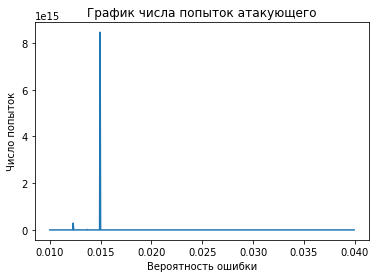

In [ ]:
plt.plot(p[:len(attempts)],attempts[:])
plt.xlabel('Вероятность ошибки')
plt.ylabel('Число попыток')
plt.title('График числа попыток атакующего')
plt.show()

In [ ]:
# найдем максимум
max_idx = np.argmax(attempts)
p_A, p_B, t_B, r_B = unoptimised_prob(p[max_idx])
r_B_result = optimised_code_params(p[max_idx])[0] 
t_fact = errors_of_H_product(noise, stat=False)
print(f'Probability of error: {round(p[max_idx], 4)} gives max amount of attempts: {attempts[max_idx] // 1e11 / 10}e12 with k = {n - r_B_result} and t = {t_fact}')

probability of errors in columns [0.11352559106695473, 0.005894161892403213, 0.00017687390543971208, 3.3325513864068732e-06]
external code error probability  [0.9999999999999618, 0.7785278123919612, 0.044104646812993295, 0.0008494410400637194]
t_B [67 15  5  3]
Probability of error: 0.0149 gives max amount of attempts: 8458.2e12 with k = 121 and t = 30


100%|██████████| 600/600 [10:37<00:00,  1.06s/it]


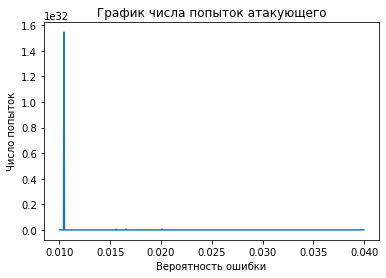

In [ ]:
# Для системы поболее
n_B = 512
n = n_B

attempts = attempts_count(p)

plt.plot(p[:len(attempts)],attempts[:])
plt.xlabel('Вероятность ошибки')
plt.ylabel('Число попыток')
plt.title('График числа попыток атакующего')
plt.show()

In [ ]:
max_idx = np.argmax(attempts)
p_A, p_B, t_B, r_B = unoptimised_prob(p[max_idx])
r_B_result = optimised_code_params(p[max_idx])[0] 
t_fact = errors_of_H_product(noise, stat=False)
print(f'Probability of error: {round(p[max_idx], 4)} gives max amount of attempts: {attempts[max_idx] // 1e11 / 10}e12 with k = {n - r_B_result} and t = {t_fact}')

probability of errors in columns [0.08060540748224386, 0.0029323359502501077, 6.144252264900544e-05, 8.072110054674501e-07]
external code error probability  [0.9999999999999926, 0.7776631176556587, 0.03096983552127769, 0.0004132068081489614]
t_B [87 15  5  2]
Probability of error: 0.0104 gives max amount of attempts: 1.5445734726781574e+20e12 with k = 338 and t = 30


100%|██████████| 600/600 [23:29<00:00,  2.35s/it]


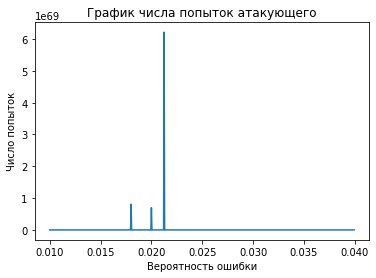

In [ ]:
# Для системы еще больше
n_B = 1024
n = n_B

attempts = attempts_count(p)

plt.plot(p[:len(attempts)],attempts[:])
plt.xlabel('Вероятность ошибки')
plt.ylabel('Число попыток')
plt.title('График числа попыток атакующего')
plt.show()

In [ ]:
max_idx = np.argmax(attempts)
p_A, p_B, t_B, r_B = unoptimised_prob(p[max_idx])
r_B_result = optimised_code_params(p[max_idx])[0] 
t_fact = errors_of_H_product(noise, stat=False)
print(f'Probability of error: {round(p[max_idx], 4)} gives max amount of attempts: {attempts[max_idx] // 1e11 / 10}e12 with k = {n - r_B_result} and t = {t_fact}')

probability of errors in columns [0.157879575855385, 0.01161089426704872, 0.0004959689100806722, 1.3328473124206894e-05]
external code error probability  [0.999999999999972, 0.9999935994004725, 0.3983011150857154, 0.013555729674325535]
t_B [243  40  10   4]
Probability of error: 0.0212 gives max amount of attempts: 6.214853034191263e+57e12 with k = 540 and t = 30
